Import the packages

In [1]:
import numpy as np
import vector

Define masses of the parent and daughter particles (in $MeV/c^2$)

In [2]:
mp = 105.7 #muon
m1 = 0.511 #electron
m2 = 0.12*1e-6 #electron antineutrino is less than this
m3 = 0.12*1e-6 #muon neutrino is less than this

Sample $s_{12}$

In [3]:
#number of simulations
N = 100000

s12max = (mp-m3)**2
s12min = (m1+m2)**2
s12 = np.random.uniform(s12min,s12max,N)

Calculate magnitude of momentum of daughter particles in COM frame when the parent particle decays into $p_{12}$ and $p_3$

In [4]:
p3 = np.sqrt(s12**2+(m3**2-mp**2)**2-(2*s12*(m3**2+mp**2)))/(2*mp)


Sample Angles in the lab rest frame

In [5]:
cos_theta = np.random.uniform(-1,1,N)
phi = np.random.uniform(0,2*np.pi,N)
theta = np.arccos(cos_theta)

Spatial momentum components and energy of daughter particle $p_3$

In [6]:
p3x = p3*np.sin(theta)*np.cos(phi)
p3y = p3*np.sin(theta)*np.sin(phi)
p3z = p3*cos_theta

E3 = np.sqrt(m3**2+p3**2)

4-vector of daughter particle $p_3$

In [7]:
daughter3= vector.array(
    {
        "E": E3,
        "px": p3x,
        "py": p3y,
        "pz": p3z,
    }
)


Now we look at the decay of $p_{12}$ to $p_1$ and $p_2$

In [8]:
p12 = np.sqrt(m1**4+(m2**2-s12)**2-(2*(m1**2)*(m2**2+s12)))/(2*np.sqrt(s12))

cos_theta12 = np.random.uniform(-1,1,N)
phi12 = np.random.uniform(0,2*np.pi,N)
theta12 = np.arccos(cos_theta)

p12x = p12*np.sin(theta12)*np.cos(phi12)
p12y = p12*np.sin(theta12)*np.sin(phi12)
p12z = p12*cos_theta12

E1 = np.sqrt(m1**2+p12**2)
E2 = np.sqrt(m2**2+p12**2)

daughter1 = vector.array(
    {
        "E": E1,
        "px": p12x,
        "py": p12y,
        "pz": p12z,
    }
)

daughter2 = vector.array(
    {
        "E": E2,
        "px": -p12x,
        "py": -p12y,
        "pz": -p12z,
    }
)

This is all in the rest frame of $p_{12}$ so we Lorentz boost this to the rest frame of the parent particle.

Using conservation of energy, $E_{init} = m_p$ and $E_{f}=E_{12}+E_3$. Therefore $E_{12}=m_p-E_3$ and by conservation of spatial momentum, it has the negative signs of $p_3$'s spatial momentum.

In [9]:
daughter12 = vector.array({
    "E": mp - daughter3.E,
    "px": -daughter3.px,
    "py": -daughter3.py,
    "pz": -daughter3.pz,
})

boosted_1 = daughter1.boostCM_of_p4(daughter12)
boosted_2 = daughter2.boostCM_of_p4(daughter12)

#print("Daughter 1:", boosted_1[0:3])
#print("Daughter 2:", boosted_2[0:3])
#print("Daughter 3:", daughter3[0:3])


For some reason this led to some negative values for the boosted electron antineutrinos' energies so I instead just went with this method to prevent any negative energies.

In [10]:
daughter12 = daughter1+daughter2

boosted_1 = daughter1.boostCM_of_p4(daughter12)
boosted_2 = daughter2.boostCM_of_p4(daughter12)

We want to verify the kinematics make sense so we create a histogram

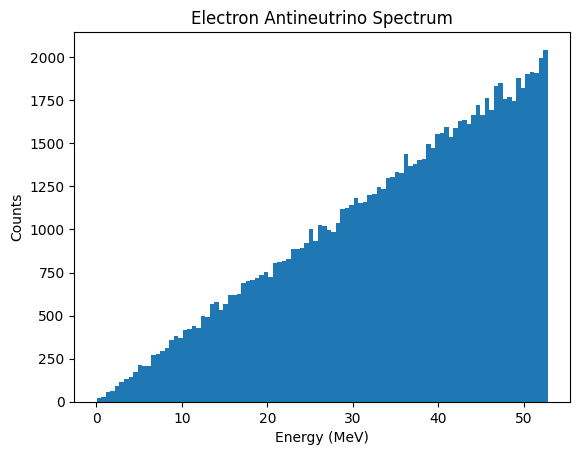

In [11]:
import matplotlib.pyplot as plt

energies2 = boosted_2.E
plt.hist(energies2, bins=100)
plt.title("Electron Antineutrino Spectrum")
plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.show()

In [12]:
print(np.max(energies2))
print(np.min(energies2))

52.84847115824478
0.030562685096710913


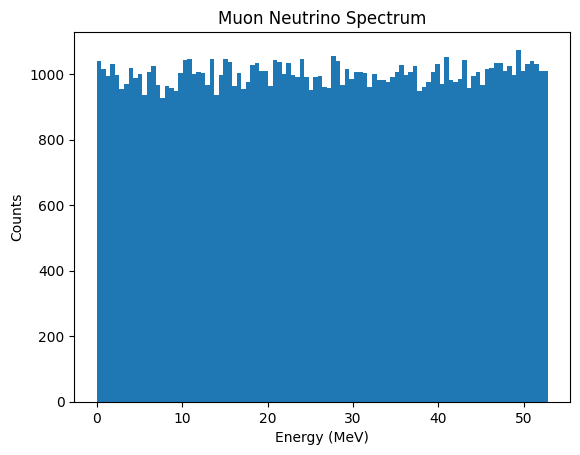

In [12]:
energies3 = daughter3.E
plt.hist(energies3, bins=100)
plt.title("Muon Neutrino Spectrum")
plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.show()

In [14]:
print(np.max(energies3))

52.84860794684714


Now let's make this a bit more realistic and add "weights" to this distribution to reflect the matrix element contributions. By https://arxiv.org/pdf/hep-ph/0203052, we can use equations 6 and 7 to weigh the electron antineutrino and muon neutrino distributions.

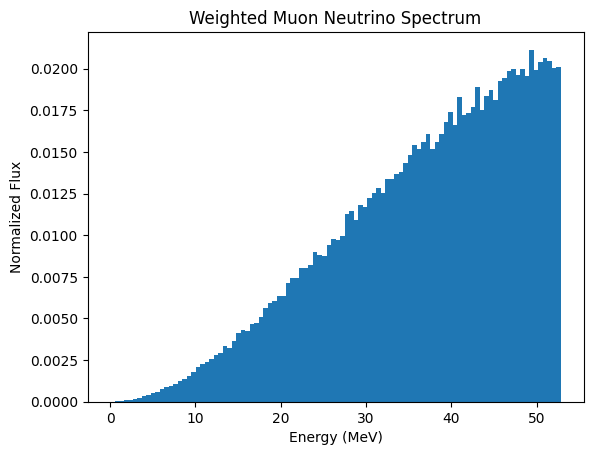

In [14]:
#muon neutrino

xmuon = 2*daughter3.E/mp
weight_muon = (xmuon**2)*(3.0-2*xmuon)

#normalize
tot_weight = np.sum(weight_muon)
norm_weight = weight_muon/tot_weight

plt.hist(daughter3.E,weights=norm_weight, bins=100)
plt.title("Weighted Muon Neutrino Spectrum")
plt.xlabel("Energy (MeV)")
plt.ylabel("Normalized Flux")
plt.show()

In [16]:
print(np.max(daughter3.E))

52.84860794684714


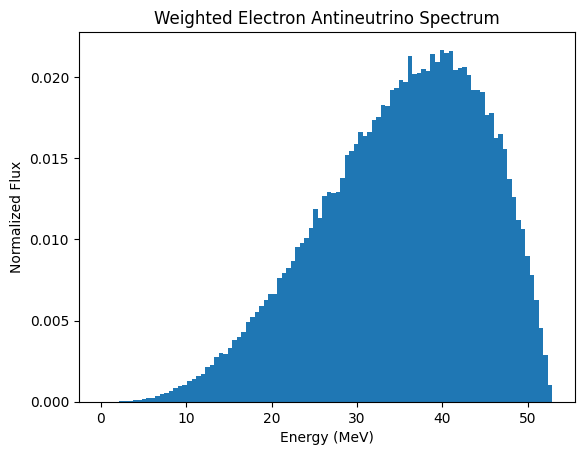

In [15]:
#electron antineutrino

xelec = 2*boosted_2.E/mp
weight_elec = (6*xelec**2)*(1-xelec)

#normalize
tot_weight_elec = np.sum(weight_elec)
norm_weight_elec = weight_elec/tot_weight_elec

plt.hist(boosted_2.E,weights=norm_weight_elec, bins=100)
plt.title("Weighted Electron Antineutrino Spectrum")
plt.xlabel("Energy (MeV)")
plt.ylabel("Normalized Flux")
plt.show()

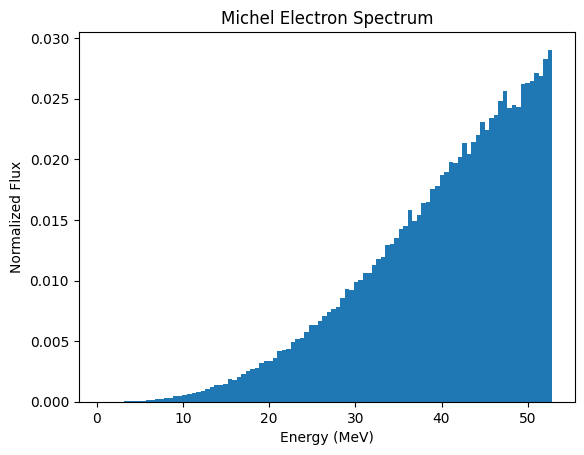

In [23]:
#electron

xe = 2*boosted_1.E/mp
weight_e = (xe**2)*(3.0-2*xe)

#normalize
tot_weight_e = np.sum(weight_e)
norm_weight_e = weight_e/tot_weight_e

plt.hist(boosted_1.E,weights=norm_weight_e, bins=100)
plt.title("Michel Electron Spectrum")
plt.xlabel("Energy (MeV)")
plt.ylabel("Normalized Flux")
plt.show()

Boosting now to have parent particle energy at 5 TeV. We can use the relativistic energy momentum equation ($E^2-p^2=m^2$) to find the relativistic momentum of this traveling muon and boost everything to this frame.

In [16]:
tot_energy = 5000000 #5 TeV
rel_mom = np.sqrt((tot_energy**2)-(mp**2))

parent = vector.array({
    "E": [tot_energy],
    "px": [rel_mom],
    "py": [0],
    "pz": [0],
}) #assume to be traveling along the x-axis

boosted_3 = daughter3.boost(parent)

print("Daughter 3:", boosted_3[0:3])

Daughter 3: [(1665425.69906777, -20.84926111, -28.04691887, 1665425.69943444)
 (3389823.29926128,  -8.73346305,  -1.58101632, 3389823.2992729 )
 (  49026.44834987,  -0.84166556,  -0.398852  ,   49026.44835871)]


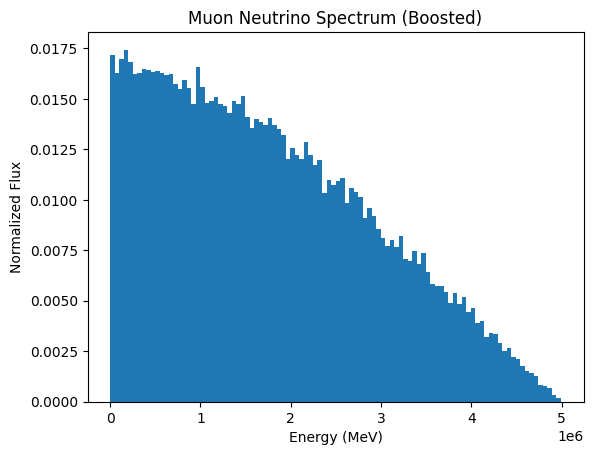

In [17]:
plt.hist(boosted_3.E,weights=norm_weight, bins=100)
plt.title("Muon Neutrino Spectrum (Boosted)")
plt.xlabel("Energy (MeV)")
plt.ylabel("Normalized Flux")
plt.show()

In [18]:
#boost the boosted electron antineutrino
doub_boosted_2 = boosted_2.boost(parent)

print("Daughter 2 (boosted twice):", doub_boosted_2[0:3])

Daughter 2 (boosted twice): [(1990709.71145447, -14.43684449, -25.27245904, 1990709.71165984)
 (2111436.03717584, -25.29031828,   8.24176726, 2111436.03732769)
 (4355963.26905152,  25.87371061,  -6.24343968, 4355963.26918545)]


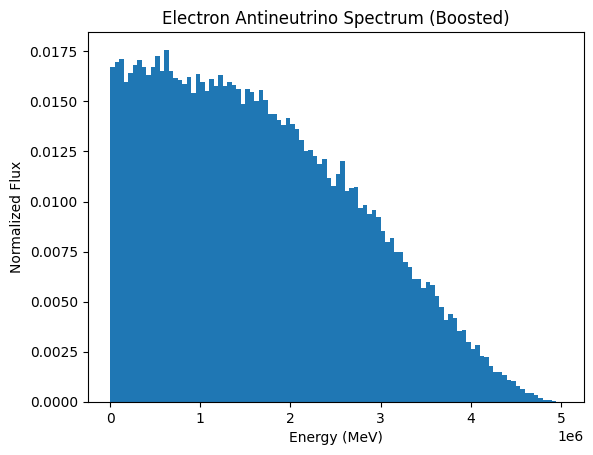

In [20]:
plt.hist(doub_boosted_2.E,weights=norm_weight_elec, bins=100)

plt.title("Electron Antineutrino Spectrum (Boosted)")
plt.xlabel("Energy (MeV)")
plt.ylabel("Normalized Flux")
plt.show()

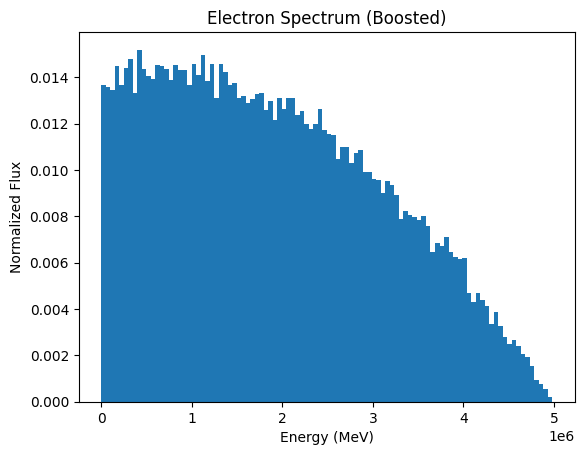

In [22]:


#boost the boosted electron
doub_boosted_1 = boosted_1.boost(parent)

plt.hist(doub_boosted_1.E,weights=norm_weight_e, bins=100)

plt.title("Electron Spectrum (Boosted)")
plt.xlabel("Energy (MeV)")
plt.ylabel("Normalized Flux")
plt.show()